In [3]:
!pip install pygsl

In [4]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import warnings
warnings.filterwarnings("ignore")
from pygsl import odeiv
matplotlib.style.use('ggplot')

class FHNmodel:
    def __init__(self, I, xc, a, epsilon):
        self.I = I
        self.xc = xc
        self.yc = xc*(-a - xc)*(xc - a) + I
        self.a = a
        self.epsilon = epsilon
    def rhs(self, x, y):
        return array([(x*(-self.a - x)*(x - self.a) - y + self.I)/self.epsilon, x - self.xc])
    def nullclines(self, x):
        return array([x*(-self.a - x)*(x - self.a) + self.I, (x - self.xc)/1e-3 ])
    def _rhs(self, t, z, pars):
        x = z[0]
        y = z[1]
        return self.rhs(x, y)
    def gslint(self, tpoints, y0):
        if isscalar(tpoints):
            tpoints = array([tpoints])
        #stepper = odeiv.step_rk2
        #stepper = odeiv.step_rk4
        #stepper = odeiv.step_rkf45
        #stepper = odeiv.step_rkck
        stepper = odeiv.step_rk8pd
        #stepper = odeiv.step_rk2imp
        # stepper = odeiv.step_rk4imp
        #stepper = odeiv.step_gear1
        #stepper = odeiv.step_gear2
        #stepper = odeiv.step_bsimp
        step = stepper(2, self._rhs, None)
        control = odeiv.control_y_new(step, 1e-12, 1e-12)
        evolve = odeiv.evolve(step, control, 2)
        t0 = 0.; h0 = 1e-4; t = t0; y = y0; h = h0;
        sol = {'x': zeros(tpoints.size)*nan,
               'y': zeros(tpoints.size)*nan}
        j = 0
        while (j < tpoints.size):
            while (t < tpoints[j]):
                t, h, y = evolve.apply(t, tpoints[j], h, y)
            sol['x'][j], sol['y'][j] = y[0], y[1]
            j += 1
        sol['t'] = tpoints
        return sol

Populating the interactive namespace from numpy and matplotlib


# Fitz-Hugh Nagumo
\begin{align}
  \varepsilon \dot{x} &= x(-a - x)(x - a) - y \\
  \dot{y} &= x - x_{c}
\end{align}
At the fixed point, the Jacobian Matrix is
\begin{equation}
J = \frac{1}{\varepsilon}
  \begin{bmatrix}
    a^2 - 3 x_c^2 & -1 \\
    \varepsilon & 0 
  \end{bmatrix}
\end{equation}
We have
\begin{equation}
{\rm Tr}(J) = \frac{a^2 - 3 x_c^2}{\varepsilon}, \quad
\vert J \vert = \frac{1}{\varepsilon}
\end{equation}
The eigenvalues are
\begin{equation}
  \lambda_{\pm} = \frac{1}{2\varepsilon}\left[a^2 - 3x_c^2 \pm \sqrt{\left(a^2 - 3x_c^2\right)^2 - 4\varepsilon}\right]
\end{equation}
The value of $x_c$ that causes a change in stability is 
$$ x_c = \pm \frac{a}{\sqrt{3}}$$

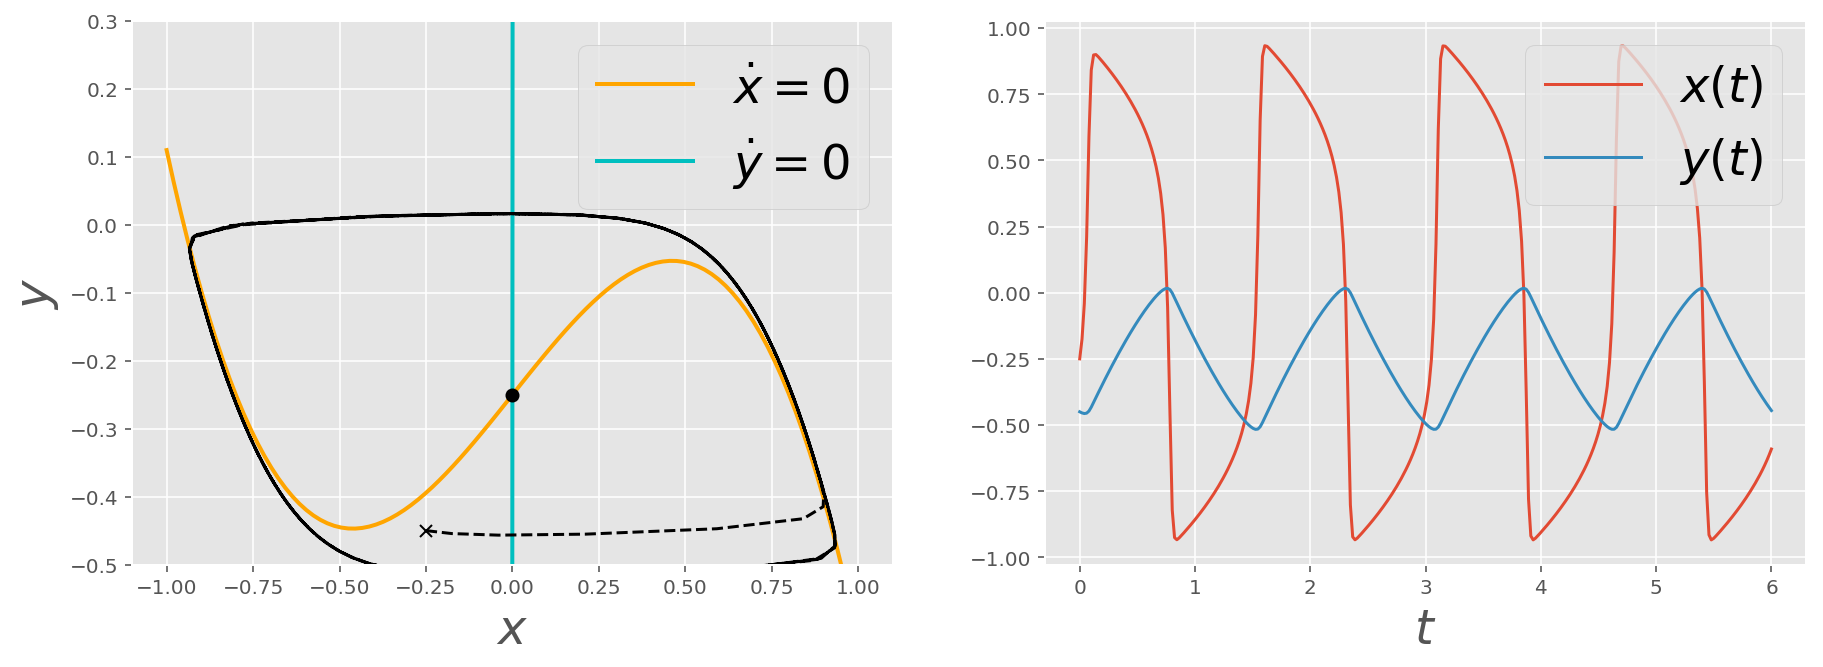

In [9]:
params = {
    'I': -0.25,
    'xc': -0.8/sqrt(3.) + 0.9, 
    'epsilon': 0.02,
    'a': 0.8}

model = FHNmodel(**params)
y0 = (-0.25, -0.45)
tpoints = linspace(0, 6, 300)
sol = model.gslint(tpoints, y0)

fig = figure(1, [15, 5])

fig.add_subplot(121)
Xnc = linspace(-1, 1, 100)
Ync = model.nullclines(Xnc)
plot(Xnc, Ync[0], 'orange', lw=2, label='$\dot{x}=0$')
plot(Xnc, Ync[1], 'c', lw=2, label='$\dot{y}=0$')
plot(model.xc, model.yc, 'ko')

plot(sol['x'][0], sol['y'][0], 'kx')
plot(sol['x'], sol['y'], '--k')
ylim(-0.5, 0.3)
xlabel('$x$', fontsize=24)
ylabel('$y$', fontsize=24)
legend(fontsize=24);

fig.add_subplot(122)
plot(sol['t'], sol['x'], label='$x(t)$')
plot(sol['t'], sol['y'], label='$y(t)$')
xlabel('$t$', fontsize=24)
legend(fontsize=24);